# Preface

In this notebook, we introduce basic linear models for regression and classification. We will use basic functionalities of the machine learning library `scikit-learn`. Install this by
```
$pip install scikit-learn
```
Documentation is found [here](https://scikit-learn.org/stable/).

We will also need `pandas`, `numpy` and plotting libraries `matplotlib` and `seaborn`.
```
$pip install numpy pandas matplotlib seaborn
```

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [22]:
sns.set_context('notebook', font_scale=1.25, rc={"lines.linewidth": 2.5})
sns.set_style("darkgrid")
np.random.seed(123)  # For reproducibility

# Singapore Housing Dataset

This dataset is obtained from a [Govtech database](https://data.gov.sg). Read the description in the website for more information. We are going to only use a subset of this data as a simple demonstration.

## Load Data

The data has been downloaded into the repository for convenience. You also also get this (and more) [here](https://data.gov.sg/dataset/resale-flat-prices). We will only use the dataset `resale-flat-prices-based-on-registration-date-from-jan-2017-onwards.csv` in this simple demo. Besure to place the data in a directory `data/` relative to the directory of this notebook. 

In [23]:
raw_dataset = pd.read_csv('./data/resale-flat-prices-based-on-registration-date-from-jan-2017-onwards.csv')

In [24]:
raw_dataset.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price
0,2017-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,61 years 04 months,232000.0
1,2017-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,60 years 07 months,250000.0
2,2017-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,262000.0
3,2017-01,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1980,62 years 01 month,265000.0
4,2017-01,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,265000.0


## Preprocess Data

Some data should be numerical but we can't easily work with them, so let's do some preprocessing.

In [25]:
def convert_to_years(years_and_months):
    """
    Convert n years m months to (n + m/12) years
    
    """
    split = years_and_months.split(' ')
    if len(split) == 2:
        return float(split[0])
    elif len(split) == 4:
        return float(split[0]) + float(split[2]) / 12.0
    else:
        raise ValueError('Wrong format.')

def average_storey(storey_range):
    """
    Convert n TO m to (n+m)/2
    """
    split = storey_range.split(' TO ')
    if len(split) == 2:
        return 0.5 * (float(split[0]) + float(split[1]))
    else:
        raise ValueError('Wrong format.')

dataset = raw_dataset.copy()
dataset['remaining_lease'] = dataset['remaining_lease'].apply(convert_to_years)
dataset['storey'] = dataset['storey_range'].apply(average_storey)

In [26]:
dataset.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,storey
0,2017-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,61.333333,232000.0,11.0
1,2017-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,60.583333,250000.0,2.0
2,2017-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62.416667,262000.0,2.0
3,2017-01,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1980,62.083333,265000.0,5.0
4,2017-01,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62.416667,265000.0,2.0


## Some Visualizations

We will visualize the data to find some patterns. The `seaborn` plotting library has some useful tools to do this.

/var/folders/jp/0cng8jvx1gd8__xdtph19cth0000gn/T/ipykernel_2485/1942723615.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  a.set_xticklabels(a.get_xticklabels(), rotation=45)


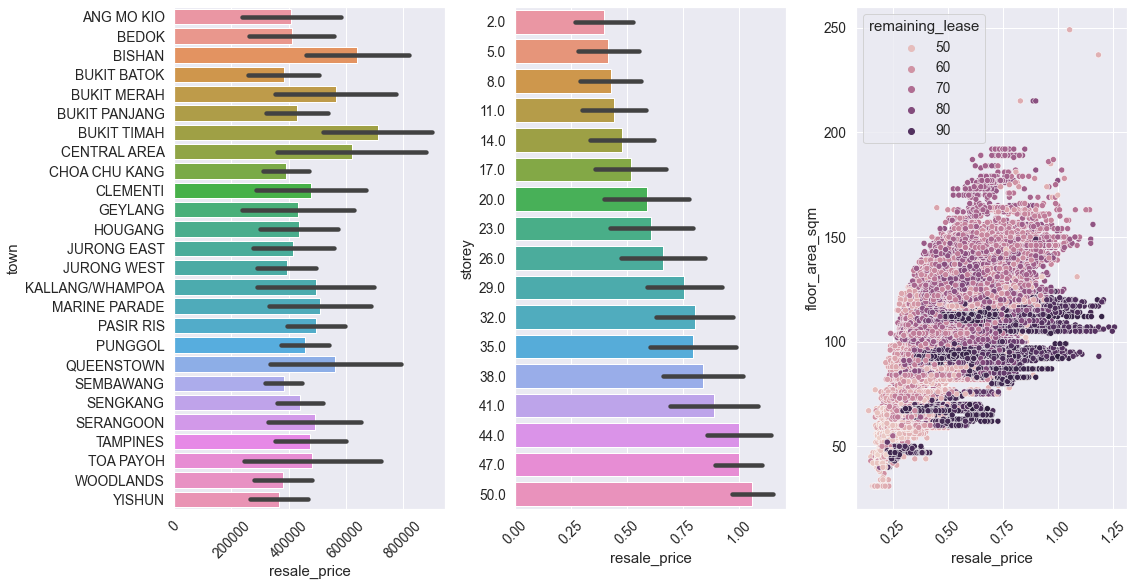

In [27]:
fig, ax = plt.subplots(1, 3, figsize=(16, 8))

sns.barplot(
    x='resale_price',
    y='town',
    data=dataset,
    orient='h',
    ci="sd",
    ax=ax[0]
)

sns.barplot(
    x='resale_price',
    y='storey',
    data=dataset,
    orient='h',
    ci="sd",
    ax=ax[1]
)

sns.scatterplot(
    x='resale_price',
    y='floor_area_sqm',
    hue='remaining_lease',
    data=dataset,
    ax=ax[2]
)

fig.tight_layout()

for a in ax:
    a.set_xticklabels(a.get_xticklabels(), rotation=45)

## Train Test Split

We will know proceed to fit some models to predict the *resale_price* given some input descriptors. This is a classical regression problem. 

To evaluate our machine learning models, we should have at least 1 hold-out test set that is untouched by our learning algorithm, until evaluation time. Since no hyper-parameter tuning is performed, it is sufficient to keep a single test set for this purpose. We use some handy functions from `sklearn`. 

In [28]:
from sklearn.model_selection import train_test_split

In [29]:
dataset_train, dataset_test = train_test_split(dataset, test_size=0.1)

In [30]:
dataset_train.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,storey
60749,2019-11,BUKIT BATOK,4 ROOM,130,BT BATOK WEST AVE 6,04 TO 06,103.0,Model A,1984,64.000000,360000.0,5.0
26245,2018-04,TOA PAYOH,5 ROOM,121,LOR 2 TOA PAYOH,01 TO 03,122.0,Improved,2002,82.750000,808000.0,2.0
5917,2017-04,YISHUN,3 ROOM,107,YISHUN RING RD,07 TO 09,67.0,New Generation,1982,64.083333,290000.0,8.0
14393,2017-09,PUNGGOL,4 ROOM,203B,PUNGGOL FIELD,07 TO 09,85.0,Model A,2004,86.166667,360000.0,8.0
45404,2019-03,CHOA CHU KANG,4 ROOM,687A,CHOA CHU KANG DR,13 TO 15,90.0,Model A,2002,82.250000,317000.0,14.0


In [31]:
dataset_test.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,storey
739,2017-01,PUNGGOL,5 ROOM,203B,PUNGGOL FIELD,01 TO 03,110.0,Improved,2004,86.833333,405000.0,2.0
10423,2017-07,JURONG EAST,4 ROOM,341,JURONG EAST AVE 1,10 TO 12,104.0,Model A,1983,64.833333,425000.0,11.0
1835,2017-02,PUNGGOL,5 ROOM,267C,PUNGGOL FIELD,04 TO 06,113.0,Premium Apartment,2013,94.916667,590000.0,5.0
75901,2020-08,BUKIT PANJANG,4 ROOM,203,PETIR RD,04 TO 06,104.0,Model A,1988,67.250000,375000.0,5.0
30317,2018-07,BEDOK,2 ROOM,535,BEDOK NTH ST 3,04 TO 06,45.0,Improved,1986,66.500000,240000.0,5.0


## Simple Linear Regression

We can see from the visualization that floor area is related to price. Rather, we should know this without seeing any data. We now try to regress the resale price from floor area alone and see how we do. 

Instead of coding our own ordinary least squares solver, `sklearn` (and many other libraries) have ready-made implementations. 

In [32]:
from sklearn.linear_model import LinearRegression

In [33]:
inputs = 'floor_area_sqm'
outputs = 'resale_price'

x_train = dataset_train[inputs][:, np.newaxis]
x_test = dataset_test[inputs][:, np.newaxis]

y_train = dataset_train[outputs]
y_test = dataset_test[outputs]

/var/folders/jp/0cng8jvx1gd8__xdtph19cth0000gn/T/ipykernel_2485/3406486357.py:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x_train = dataset_train[inputs][:, np.newaxis]
/var/folders/jp/0cng8jvx1gd8__xdtph19cth0000gn/T/ipykernel_2485/3406486357.py:5: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x_test = dataset_test[inputs][:, np.newaxis]


In [34]:
regressor = LinearRegression()
regressor.fit(
    X=x_train,
    y=y_train,
)
y_hat_train = regressor.predict(x_train)
y_hat_test = regressor.predict(x_test)

### Visualizing Regression Result

Since we are working in one dimension, it is possible to visualize our linear fit.

Note that the following can be directly reproduced by a single `sns.regplot` call from `seaborn`, without explicitly using `LinearRegression()` from `sklearn`. 

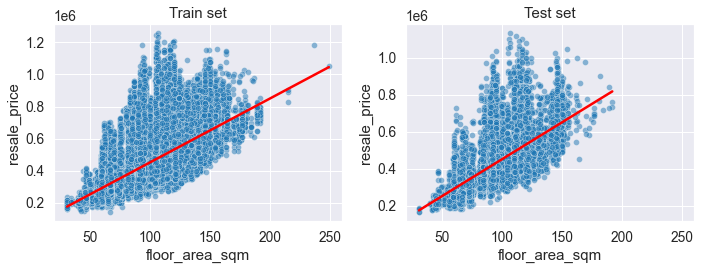

In [35]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharex=True)

sns.scatterplot(
    x=x_train.ravel(),
    y=y_train,
    ax=ax[0],
    alpha=0.5,
)
sns.lineplot(
    x=x_train.ravel(),
    y=y_hat_train,
    ax=ax[0],
    color='red',
)

sns.scatterplot(
    x=x_test.ravel(),
    y=y_test,
    ax=ax[1],
    alpha=0.5,
)
sns.lineplot(
    x=x_test.ravel(),
    y=y_hat_test,
    ax=ax[1],
    color='red',
)



for a in ax:
    a.set_xlabel(inputs)
    a.set_ylabel(outputs)

    
ax[0].set_title('Train set')
ax[1].set_title('Test set')




fig.tight_layout()

Alternatively, we can directly compare our predicted resale prices with the ground truth. This works if we have higher dimensional inputs so that a linear fit is difficult to plot graphically.

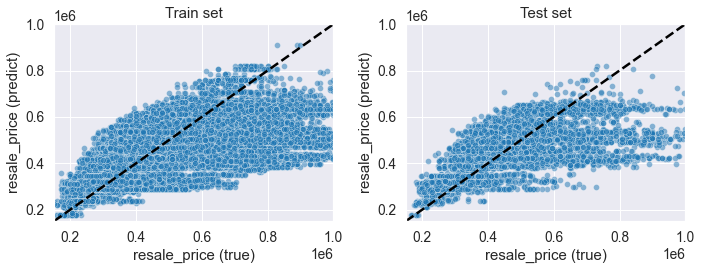

In [36]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

sns.scatterplot(
    x=y_train,
    y=y_hat_train,
    ax=ax[0],
    alpha=0.5,
)

sns.scatterplot(
    x=y_test,
    y=y_hat_test,
    ax=ax[1],
    alpha=0.5,
)

for a in ax:
    a.set_xlabel('{} (true)'.format(outputs))
    a.set_ylabel('{} (predict)'.format(outputs))
    a.set_xlim(1.5*10**5, 10**6)
    a.set_ylim(1.5*10**5, 10**6)
    a.plot(a.get_xlim(), a.get_ylim(), ls='--', c='k')


    
ax[0].set_title('Train set')
ax[1].set_title('Test set')

fig.tight_layout()

### Quantifying the Error

Just looking at the fit doesn't tell us very precise information. Therefore, it is often better to quantify the error. One simple metric is the mean-square difference between the predicted outputs and the actual outputs. But this is not the only one! You are encouraged to look at [`sklearn.metrics`](https://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics) to find more ways to evaluate the results. 

In [37]:
from sklearn.metrics import mean_squared_error
def rmse_scaled(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    scale = np.sqrt(np.mean(y_true**2))
    return rmse/scale

In [38]:
print(
    'Scaled RMSE: \n {} (Train) \n {} (Test)'.format(
        rmse_scaled(y_train, y_hat_train),
        rmse_scaled(y_test, y_hat_test),
    )
)

Scaled RMSE: 
 0.25524977033578355 (Train) 
 0.2573959287861703 (Test)


## Polynomial Regression

Simple linear regression gave about 26% error. Can we do better by going to larger hypothesis spaces? Let us now try a **polynomial regression** up to degree 3. This is an example of a linear basis model. 

In [39]:
from sklearn.preprocessing import PolynomialFeatures

In [40]:
phi = PolynomialFeatures(degree=3)
x_poly_train = phi.fit_transform(x_train)
x_poly_test = phi.fit_transform(x_test)

In [41]:
regressor_poly = LinearRegression()
regressor_poly.fit(
    X=x_poly_train,
    y=y_train,
)
y_hat_poly_train = regressor_poly.predict(x_poly_train)
y_hat_poly_test = regressor_poly.predict(x_poly_test)

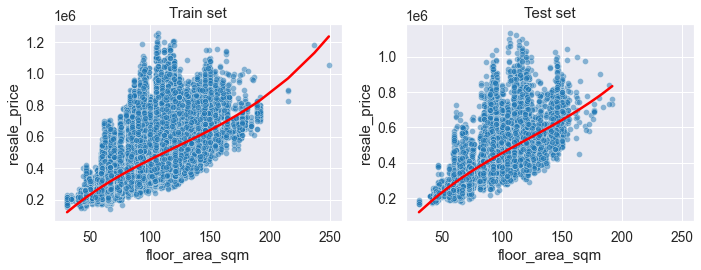

In [42]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharex=True)

sns.scatterplot(
    x=x_train.ravel(),
    y=y_train,
    ax=ax[0],
    alpha=0.5,
)
sns.lineplot(
    x=x_train.ravel(),
    y=y_hat_poly_train,
    ax=ax[0],
    color='red',
)

sns.scatterplot(
    x=x_test.ravel(),
    y=y_test,
    ax=ax[1],
    alpha=0.5,
)
sns.lineplot(
    x=x_test.ravel(),
    y=y_hat_poly_test,
    ax=ax[1],
    color='red',
)



for a in ax:
    a.set_xlabel(inputs)
    a.set_ylabel(outputs)

    
ax[0].set_title('Train set')
ax[1].set_title('Test set')




fig.tight_layout()

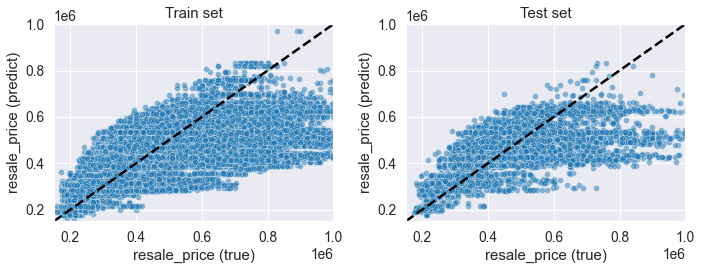

In [43]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

sns.scatterplot(
    x=y_train,
    y=y_hat_poly_train,
    ax=ax[0],
    alpha=0.5,
)

sns.scatterplot(
    x=y_test,
    y=y_hat_poly_test,
    ax=ax[1],
    alpha=0.5,
)

for a in ax:
    a.set_xlabel('{} (true)'.format(outputs))
    a.set_ylabel('{} (predict)'.format(outputs))
    a.set_xlim(1.5*10**5, 10**6)
    a.set_ylim(1.5*10**5, 10**6)
    a.plot(a.get_xlim(), a.get_ylim(), ls='--', c='k')


    
ax[0].set_title('Train set')
ax[1].set_title('Test set')

fig.tight_layout()

In [44]:
print(
    'Scaled RMSE: \n {} (Train) \n {} (Test)'.format(
        rmse_scaled(y_train, y_hat_poly_train),
        rmse_scaled(y_test, y_hat_poly_test),
    )
)

Scaled RMSE: 
 0.25499492214682234 (Train) 
 0.2571460226124077 (Test)


Looks like polynomial regression didn't really improve on the simple linear regression result. Why?

## Including More Design Variables in Linear Regression

Clearly, the size of the house is not the only factor determining price. Let us now include some other factors which may contribute. In this case, the regression problem is defined in higher dimenions.

Note that from the viewpoint of approximation, we are also using a bigger **hypothesis space**, but not in the same way as a polynomial basis in one dimension. In the first linear regression example, we are using the hypothesis space consisting of all functions which are affine in *floor_area_sqm* and constant in the other dependent variables. Now, we are using the hypothesis space consisting of affine functions of more than one variable.

In [45]:
dataset.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,storey
0,2017-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,61.333333,232000.0,11.0
1,2017-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,60.583333,250000.0,2.0
2,2017-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62.416667,262000.0,2.0
3,2017-01,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1980,62.083333,265000.0,5.0
4,2017-01,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62.416667,265000.0,2.0


In [46]:
inputs = ['town', 'floor_area_sqm', 'remaining_lease', 'storey']
outputs = 'resale_price'

In [47]:
x_train = dataset_train[dataset_train.columns.intersection(inputs)]
x_train.head()

,town,floor_area_sqm,remaining_lease,storey
60749,BUKIT BATOK,103.0,64.000000,5.0
26245,TOA PAYOH,122.0,82.750000,2.0
5917,YISHUN,67.0,64.083333,8.0
14393,PUNGGOL,85.0,86.166667,8.0
45404,CHOA CHU KANG,90.0,82.250000,14.0


Note that the "town" column are nominal/categorical variables, so let us perform a **one-hot encoding**. 

In [48]:
x_train = pd.get_dummies(x_train)
y_train = dataset_train[outputs]
x_train.head()

,floor_area_sqm,remaining_lease,storey,town_ANG MO KIO,town_BEDOK,town_BISHAN,town_BUKIT BATOK,town_BUKIT MERAH,town_BUKIT PANJANG,town_BUKIT TIMAH,...,town_PASIR RIS,town_PUNGGOL,town_QUEENSTOWN,town_SEMBAWANG,town_SENGKANG,town_SERANGOON,town_TAMPINES,town_TOA PAYOH,town_WOODLANDS,town_YISHUN
60749,103.0,64.000000,5.0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
26245,122.0,82.750000,2.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
5917,67.0,64.083333,8.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
14393,85.0,86.166667,8.0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
45404,90.0,82.250000,14.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


we repeat this for the test set

In [49]:
x_test = dataset_test[dataset_test.columns.intersection(inputs)]
x_test = pd.get_dummies(x_test)
y_test = dataset_test[outputs]

now we train the regressor in these new variables

In [50]:
regressor = LinearRegression()
regressor.fit(
    X=x_train,
    y=y_train,
)
y_hat_train = regressor.predict(x_train)
y_hat_test = regressor.predict(x_test)

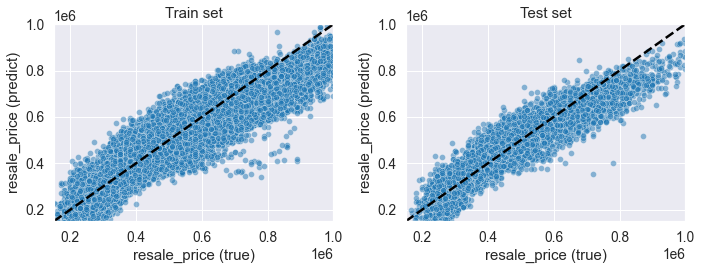

In [51]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

sns.scatterplot(
    x=y_train,
    y=y_hat_train,
    ax=ax[0],
    alpha=0.5,
)

sns.scatterplot(
    x=y_test,
    y=y_hat_test,
    ax=ax[1],
    alpha=0.5,
)

for a in ax:
    a.set_xlabel('{} (true)'.format(outputs))
    a.set_ylabel('{} (predict)'.format(outputs))
    a.set_xlim(1.5*10**5, 10**6)
    a.set_ylim(1.5*10**5, 10**6)
    a.plot(a.get_xlim(), a.get_ylim(), ls='--', c='k')


    
ax[0].set_title('Train set')
ax[1].set_title('Test set')

fig.tight_layout()

In [52]:
print(
    'Scaled RMSE: \n {} (Train) \n {} (Test)'.format(
        rmse_scaled(y_train, y_hat_train),
        rmse_scaled(y_test, y_hat_test),
    )
)

Scaled RMSE: 
 0.1320906011936788 (Train) 
 0.13011826537127308 (Test)


Observe from the fit and the RMSE that we are doing quite a bit better than the univariate linear case. Can you improve on this:
  *  Better accuracy?
  *  Smaller number of features?